 ## We deal with the low precision faced in notebook 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
import joblib


 ### Load and Preprocess Data

In [4]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv").drop(['nameOrig', 'nameDest'], axis=1)
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])


 ### Data Splitting and SMOTE Application

In [5]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)


 ### Model Training

In [6]:
# Train LightGBM model
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', learning_rate=0.05,
                               num_leaves=31, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1)
lgb_model.fit(X_train_res, y_train_res)

# Train XGBoost model
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.05, max_depth=5, n_estimators=200,
                              reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=scale_pos_weight, eval_metric='auc')
xgb_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

 ### Model Evaluation

In [7]:
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)
    roc_auc = roc_auc_score(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    print(f"\nEvaluation for {model_name} (Threshold: {threshold}):")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC and PR curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='navy')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'ROC Curve - {model_name}')
    axes[0].legend()
    
    axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.2f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'Precision-Recall Curve - {model_name}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


 ### Find Optimal Decision Threshold

In [8]:
def find_optimal_threshold(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    return optimal_threshold


Optimal Threshold: 0.9837
Optimal Threshold: 0.9872

Evaluation for LightGBM (Threshold: 0.9836957258072886):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.90      0.84      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.92      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



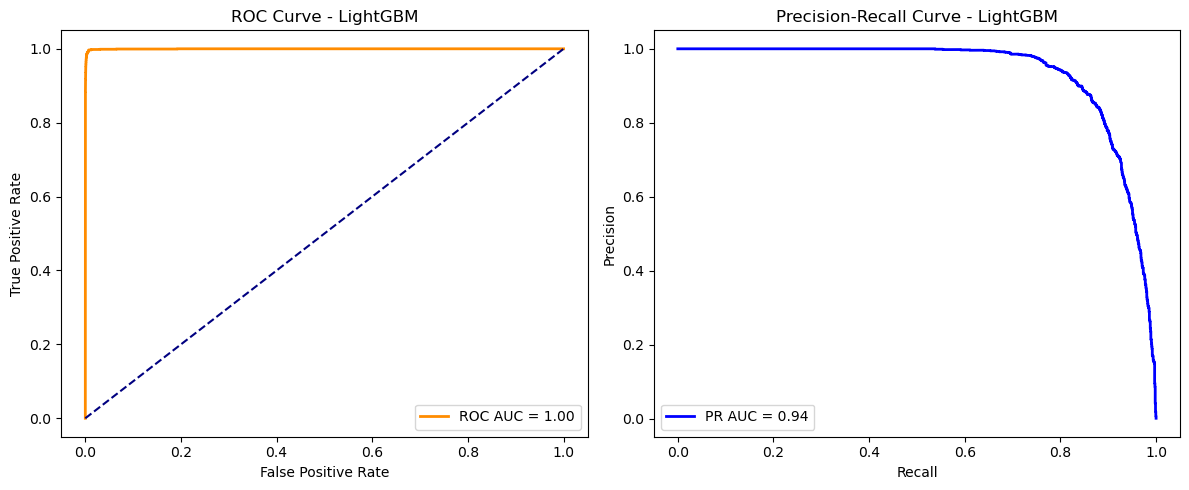


Evaluation for XGBoost (Threshold: 0.9872291088104248):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.92      0.83      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.92      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



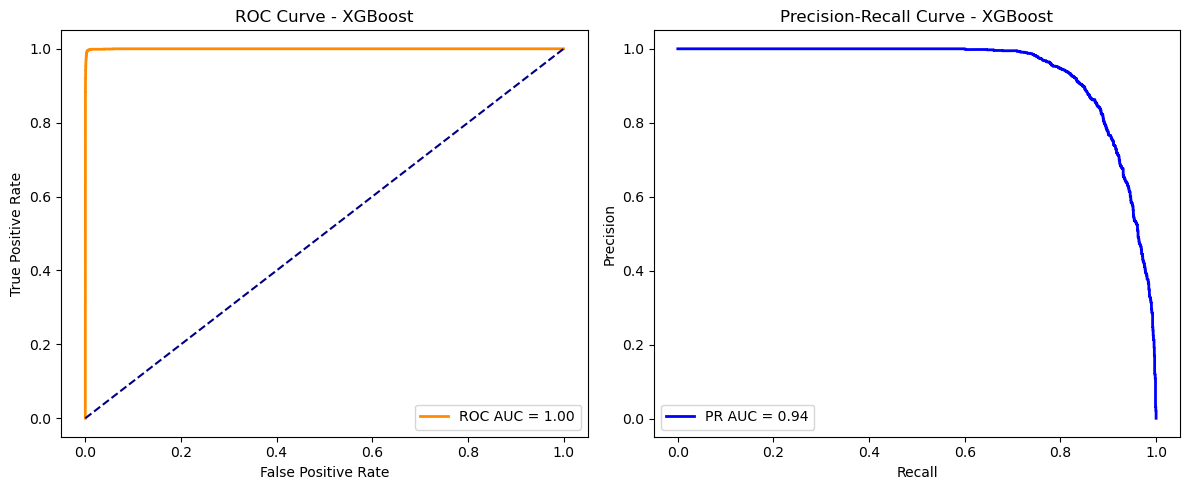

In [9]:
optimal_threshold_lgb = find_optimal_threshold(lgb_model, X_test, y_test)
optimal_threshold_xgb = find_optimal_threshold(xgb_model, X_test, y_test)

evaluate_model(lgb_model, X_test, y_test, "LightGBM", optimal_threshold_lgb)
evaluate_model(xgb_model, X_test, y_test, "XGBoost", optimal_threshold_xgb)


 ### Feature Importance Plot

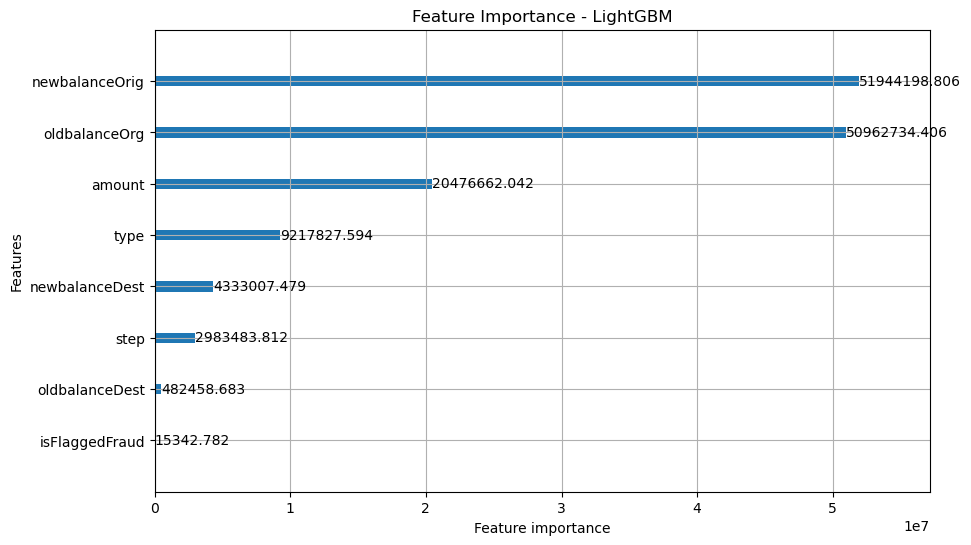

In [ ]:
lgb.plot_importance(lgb_model, importance_type='gain', figsize=(10, 6))
plt.title(f"Feature Importance - LightGBM")
plt.show()


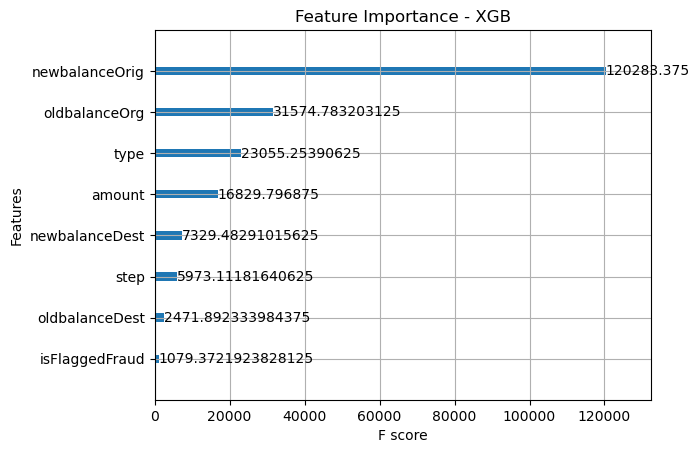

In [30]:
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title(f"Feature Importance - XGB")
plt.show()


 ### Save Models

In [14]:
joblib.dump(lgb_model, "lightgbm_fraud_detection.pkl")
joblib.dump(xgb_model, "xgboost_fraud_detection.pkl")
joblib.dump(encoder, "label_encoder.pkl")
print("Models and encoder saved successfully!")


Models and encoder saved successfully!
